# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines Finding** 


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


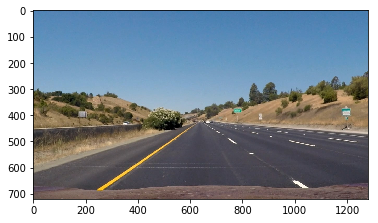

In [2]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
#Get objpoint & imgpoint
def GetPoints(path, nx=9, ny=6):

    imgs = glob.glob(path)

    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    for fname in imgs:
        # Make a list of calibration images
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
#             # for debug
#             # Draw and display the corners
#             cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
#             plt.imshow(img)
#             plt.show()
    return objpoints, imgpoints

In [4]:
#undistortion
def cal_undistort(img, objpoints, imgpoints):
    retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, cameraMatrix, distCoeffs)
    return undist

# #for debug
# imgs = glob.glob('./camera_cal/calibration*.jpg')
# for fname in imgs:
#     # Make a list of calibration images
#     img = cv2.imread(fname)

#     undistorted = cal_undistort(img, objpoints, imgpoints)

#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#     f.tight_layout()
#     ax1.imshow(img)
#     ax1.set_title('Original Image', fontsize=50)
#     ax2.imshow(undistorted)
#     ax2.set_title('Undistorted Image', fontsize=50)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#     plt.show()
        

In [5]:
#calculate absolute sobel threshold binary image
def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

In [6]:
#calculate magnitude sobel threshold binary image
def sobel_mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobel_mag = np.sqrt( sobelx**2 + sobely**2 )

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))

    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output


In [7]:
#calculate sobel direction threshold binary image
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)

    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(dir_sobel)
    
    # 6) Return this mask as your binary_output image
    binary_output[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1

    return binary_output

In [8]:
#calculate HLS(S value) threshold binary image
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)
    # 3) Return a binary image of threshold result
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output

In [9]:
def hls_select_l(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(L)
    # 3) Return a binary image of threshold result
    binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary_output

In [10]:
def luv_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
    L = hls[:,:,0]
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(L)
    # 3) Return a binary image of threshold result
    binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary_output

In [11]:
def lab_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    B = hls[:,:,2]
    # 2) Apply a threshold to the B channel
    binary_output = np.zeros_like(B)
    # 3) Return a binary image of threshold result
    binary_output[(B > thresh[0]) & (B <= thresh[1])] = 1
    return binary_output

In [12]:
#masking without region of interest
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image


In [13]:
#perspective transform 
def perspective_transform(img):
    
    ysize = img.shape[0]

#     (x1, y1) = (275, 670)
#     (x2, y2) = (1030, y1)
#     (x3, y3) = (670, 440)
#     (x4, y4) = (605, y3)
    
    (x1, y1) = (275, 670)
    (x2, y2) = (1030, y1)
    (x3, y3) = (725, 480)
    (x4, y4) = (550, y3)    

    src = np.float32([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])        
    dst = np.float32([[340,ysize], [940, ysize], [940, 0], [340, 0]])

    M    = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    # warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    # f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    # f.tight_layout()

    # #manual choosing
    # ax1.scatter(x1,y1, marker='*', s=50, c='red')
    # ax1.scatter(x2,y2, marker='*', s=50, c='red')
    # ax1.scatter(x3,y3, marker='*', s=50, c='red')
    # ax1.scatter(x4,y4, marker='*', s=50, c='red')
    # ax1.scatter(vertices[0,0,0],vertices[0,0,1], s=50, c='blue')
    # ax1.scatter(vertices[0,1,0],vertices[0,1,1], s=50, c='blue')
    # ax1.scatter(vertices[0,2,0],vertices[0,2,1], s=50, c='blue')
    # ax1.scatter(vertices[0,3,0],vertices[0,3,1], s=50, c='blue')

    # ax1.imshow(img)
    # ax1.set_title('Original Image', fontsize=20)
    # ax2.imshow(warped)
    # ax2.set_title('Mask & Warped Image', fontsize=20)
    # plt.show()

    return M, Minv
    

In [14]:
#Polyfitting left and right lane line, calculate curvature and position from center
def fitting_line(img, M, initial=None):
    binary_warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    if initial is not None:
        y_eval = len(image[0])
        left_fit  = initial[0]
        right_fit = initial[1]
        leftx_base  = int(left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2])
        rightx_base = int(right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2])
    
    # Choose the number of sliding windows
    nwindows = 12

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 20

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        #next window
        if initial is not None:
            leftx_current  = int(left_fit[0]*win_y_high**2 + left_fit[1]*win_y_high + left_fit[2])
            rightx_current = int(right_fit[0]*win_y_high**2 + right_fit[1]*win_y_high + right_fit[2])                      
        # If you found > minpix pixels, recenter next window on their mean position
        else:
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(leftx) == 0 or len(rightx) == 0:
        return 0, 0, 0, 0, 0, 0, 0, False
    
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ##calculate curvature
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30.0/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/600 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    ##calculate position from center
    xleft  = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    xright = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]

    
#     y_eval = y_eval * ym_per_pix
#     xleft  = left_fit_cr[0]*y_eval**2 + left_fit_cr[1]*y_eval + left_fit_cr[2]
#     xright = right_fit_cr[0]*y_eval**2 + right_fit_cr[1]*y_eval + right_fit_cr[2]
    
    center = (0.5 * (xleft + xright - img.shape[1])) * xm_per_pix
    
    return left_fit, right_fit, left_curverad, right_curverad, center, xleft, xright, True


In [15]:
#Fill Poly Lane
def  fillPolyLane(orgimg, combined, left_fit, right_fit, Minv):
   
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting###
    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image(undistortion)
    result = cv2.addWeighted(orgimg, 1, newwarp, 0.3, 0)

    return result


## Pipeline

In [16]:
#get the objpoints and imgpoints
objpoints, imgpoints = GetPoints(path='./camera_cal/calibration*.jpg')

#get M and Minv
testimage = mpimg.imread('./test_images/straight_lines1.jpg')
M, Minv = perspective_transform(testimage)

#smoothing size
smooth_size = 10
left_fit_history = []
right_fit_history = []

initial = None

def process_image(image):

    global initial
    
    #undistort the image
    image = cal_undistort(image, objpoints, imgpoints)

    #Calculate the binary image and combined binary image
#     grad_binary_x    = abs_sobel_thresh(image, orient='x', thresh=(20, 255))
#     grad_binary_y    = abs_sobel_thresh(image, orient='y', thresh=(20, 255))
#     grad_mag_binary  = sobel_mag_thresh(image, thresh=(90, 255))
#     grad_dir_binary  = dir_threshold(image, sobel_kernel=3, thresh=(0.7, 1.3))
#     hls_binary       = hls_select(image,(60, 255))

#     combined = np.zeros_like(grad_binary_x)
#     combined[((grad_binary_x == 1) & (grad_binary_y == 1)) | ((grad_mag_binary == 1) & (grad_dir_binary == 1)) |\
#              hls_binary == 1] = 1    

    hls_binary       = hls_select(image,(60, 255))
    Luv_binary       = luv_select(image,(130, 255))
    Lab_binary       = lab_select(image,(150, 255))
    hls_binary_l     = hls_select_l(image,(200, 255))
    combined = np.zeros_like(hls_binary)
    combined[((hls_binary_l == 1) & (Luv_binary == 1)) | ((hls_binary == 1) & (Lab_binary == 1))] = 1



    #masking without region of interest
    vertices = np.array([[(125, 690),(1180, 690),\
                      (750, 420),(525, 420)]], dtype=np.int32)
    combined = region_of_interest(combined, vertices)

    #fitting the line
    if initial is None:
        left_fit, right_fit, left_curverad, right_curverad, center, xleft, xright, Flag = fitting_line(combined, M)
    else:
        left_fit, right_fit, left_curverad, right_curverad, center, xleft, xright, Flag = fitting_line(combined, M, initial)

    #if fitting fail occur(including sanity check)
    if Flag == False or ( len(left_fit_history) != 0 and (np.abs(left_curverad-right_curverad) > 10000.0 or np.abs(center) > 1.0)):
        left_curverad = 0.0
        right_curverad = 0.0
        center = 0.0
        initial = None
        
        #prev value
        pleft_fit  = left_fit_history[-1]
        pright_fit = right_fit_history[-1]
        y_eval = len(image[0])
        xleft  = pleft_fit[0] *y_eval**2 + pleft_fit[1] *y_eval + pleft_fit[2]
        xright = pright_fit[0]*y_eval**2 + pright_fit[1]*y_eval + pright_fit[2]

        left_fit = pleft_fit
        right_fit = pright_fit
    else:
        initial = [left_fit, right_fit]

    #smoothing
    left_fit_history.append(left_fit)
    right_fit_history.append(right_fit)

    if len(left_fit_history) >= smooth_size:
        left_fit_history.pop(0)
        right_fit_history.pop(0)

    np_left_fit_history  = np.array(left_fit_history)
    np_right_fit_history = np.array(right_fit_history)    
    average_left_fit  = np.sum(np_left_fit_history, axis=0)  / np_left_fit_history.shape[0]
    average_right_fit = np.sum(np_right_fit_history, axis=0) / np_right_fit_history.shape[0]        
    
    #Fill Poly Lane
    result = fillPolyLane(image, combined, average_left_fit, average_right_fit, Minv)
    
    # Now our radius of curvature is in meters
    text = 'left:' + str(int(left_curverad))+'m,  right:' + str(int(right_curverad)) + 'm, position:' + str(int(1000*center)) + 'mm'
    cv2.putText(result, text, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0))
    #result = out_img
    return result

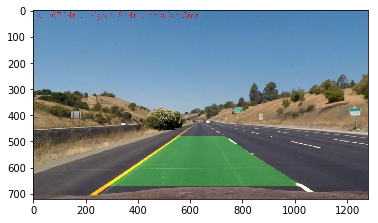

In [17]:
#reading in an image
image = mpimg.imread('./test_images/straight_lines1.jpg')

result = process_image(image)
plt.imshow(result)
plt.show()

left_fit_history = []
right_fit_history = []

initial = None

## Test on Videos

We can test our solution on provided video:

`project_video.mp4`

Let's try the project video ...

In [18]:
output = './project_video_output.mp4'

clip1 = VideoFileClip("./project_video.mp4")
#clip1 = VideoFileClip("./challenge_video.mp4")
#clip1 = VideoFileClip("./harder_challenge_video.mp4")
#clip = clip1.fl_image(process_image).subclip(39,41) #NOTE: this function expects color images!!
clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [21:28<00:00,  1.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

Wall time: 21min 29s


Video(Inline version)

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))